# 10. Logistic Regression

## 10.4 Robust logistic regression

### 10.4.1 Mixture model for the likelihood

> Robust Bayesian Binary logistic regression in 1d for iris flowers
>
> Code is based on
> https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_iris
# data: (150, 4), target: (150,)
# feature_names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
# target_names: {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
X, y = load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [3]:
# Create inliers
# targets: setosa or versicolor and feature: 'sepal length (cm)'
X_inliers = X[y != 2][:, 0]
y_inliers = y[y != 2]
n_inliers = len(X_inliers)
X_inliers.shape, y_inliers.shape, n_inliers

((100,), (100,), 100)

In [4]:
# Create outliers
X_outliers = np.array([4.2, 4.5, 4.0, 4.3, 4.2, 4.4])
y_outliers = np.ones_like(X_outliers, dtype=int) # 1: versicolor
n_outliers = len(X_outliers)
X_outliers.shape, y_outliers.shape, n_outliers

((6,), (6,), 6)

In [5]:
# Concatenate inliers and outliers
X_total = np.concatenate((X_inliers, X_outliers))
y_total = np.concatenate((y_inliers, y_outliers))
X_total.shape, y_total.shape

((106,), (106,))

#### PyMC sampling of logistic regressions on Iris dataset (2 chains and 1000 draws)

- Binary logistic regression
$$
p(y|x;\theta) = \operatorname{Ber}(y|\sigma(w^Tx+b))
$$

- Robust logistic regression
$$
p(y|x;\theta) = \pi\operatorname{Ber}(y|0.5) + (1-\pi)\operatorname{Ber}(y|\sigma(w^Tx+b))
$$

In [6]:
%%time
import pymc as pm

def infer_nonrobust_model(X, y):
    with pm.Model() as model_0:
        w = pm.Normal('w', mu=0, sigma=10) # weight
        b = pm.Normal('b', mu=0, sigma=10) # bias
        a = pm.math.dot(w, X) + b # logit

        σ = pm.Deterministic('σ', pm.math.sigmoid(a))
        bd = pm.Deterministic('bd', -b / w) # decision boundary

        yl = pm.Bernoulli('yl', p=σ, observed=y)

        trace = pm.sample(1000, chains=2, cores=1)
    return trace

def infer_robust_model(X, y):
    with pm.Model() as model_0:
        w = pm.Normal('w', mu=0, sigma=10) # weight
        b = pm.Normal('b', mu=0, sigma=10) # bias
        a = pm.math.dot(w, X) + b # logit

        σ = pm.Deterministic('σ', pm.math.sigmoid(a))
        bd = pm.Deterministic('bd', -b / w) # decision boundary

        π = pm.Beta('π', 1.0, 1.0) # uniform; probability of contamination
        p = π * 0.5 + (1 - π) * σ  # true prob p(y=1|x)
        yl = pm.Bernoulli('yl', p=p, observed=y)

        trace = pm.sample(1000, chains=2, cores=1, target_accept=0.95)
    return trace

trace_inliers = infer_nonrobust_model(X_inliers - np.mean(X_inliers), y_inliers)
trace_total = infer_nonrobust_model(X_total - np.mean(X_total), y_total)
trace_robust = infer_robust_model(X_total - np.mean(X_total), y_total)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, b, π]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


CPU times: total: 18.7 s
Wall time: 22.1 s


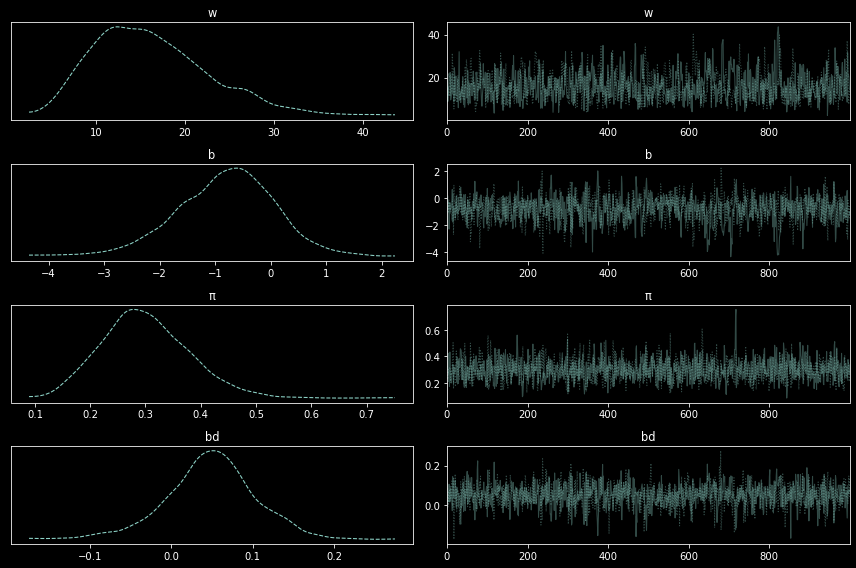

In [11]:
pm.plot_trace(trace_robust, var_names=['w', 'b', 'π', 'bd'], combined=True)
plt.gcf().tight_layout()

In [12]:
pm.summary(trace_robust, var_names=['w', 'b', 'π', 'bd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w,16.222,6.430,5.708,28.127,0.255,0.189,715.0,925.0,1.0
b,-0.824,0.913,-2.517,0.901,0.034,0.030,756.0,687.0,1.0
π,0.300,0.079,0.153,0.442,0.002,0.001,1443.0,1262.0,1.0
bd,0.049,0.056,-0.054,0.157,0.002,0.001,1229.0,1107.0,1.0


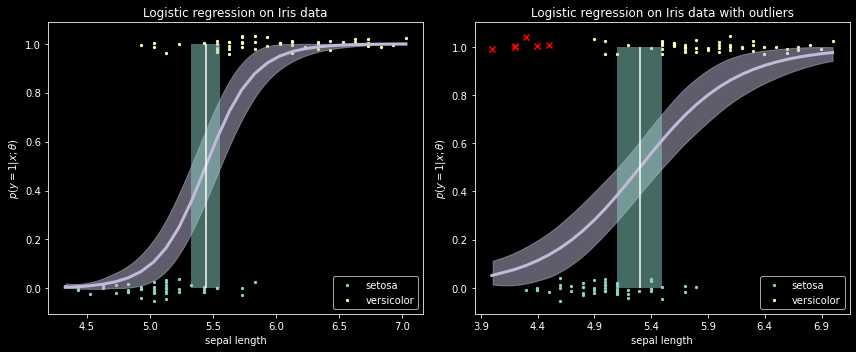

In [13]:
import arviz as az
rng = np.random.default_rng()

def plot_training_data(X, y, n_inliers, n_outliers, ax, rng=rng):
    X_mean = np.mean(X)
    X_c = X - X_mean
    inlier_ndx = np.arange(0, n_inliers)  # 0, ..., 99
    outlier_ndx = np.arange(n_inliers, n_inliers + n_outliers) # 100, ..., 105
    for c, label in enumerate(['setosa', 'versicolor']):
        ndx_c = np.where(y == c)[0]
        sigma = 0.02  # for vertical jittering
        inliers = np.intersect1d(ndx_c, inlier_ndx)
        ax.scatter(X_c[inliers], rng.normal(y[inliers], sigma), s=5, c=f'C{c}', marker='o', label=label)
        outliers = np.intersect1d(ndx_c, outlier_ndx)
        ax.scatter(X_c[outliers], rng.normal(y[outliers], sigma), c='red', marker='x')
    # use original scale for xticks
    locs = ax.get_xticks()
    ax.set_xticks(locs, labels=np.round(locs + X_mean, 1))
    ax.set_xlabel('sepal length')
    ax.set_ylabel('$p(y=1|x;\\theta)$')
    ax.legend(loc='lower right')

def make_plot(trace, X, ax):
    X_c = X - np.mean(X)
    # plot logistic curve
    theta = trace['posterior']['σ'] # (chains, draws, samples) 
    az.plot_hdi(X_c, theta, color='C2', ax=ax)
    idx = np.argsort(X_c) # to make a line plot
    ax.plot(X_c[idx], theta.mean(axis=(0, 1))[idx], color='C2', lw=3)
    # plot decision boundary
    bd = trace['posterior']['bd'].values.ravel() # (chains, draws) -> (chains * draws,)
    bd_hpd = az.hdi(bd)
    ax.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], alpha=0.5)
    ax.vlines(bd.mean(), 0, 1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

plot_training_data(X_inliers, y_inliers, n_inliers, 0, ax1)
make_plot(trace_inliers, X_inliers, ax1)
ax1.set_title("Logistic regression on Iris data")

plot_training_data(X_total, y_total, n_inliers, n_outliers, ax2)
make_plot(trace_total, X_total, ax2)
ax2.set_title("Logistic regression on Iris data with outliers")

fig.tight_layout()

#### Figure 10.10: (a) Logistic regression on some data with outliers (denoted by $\times$). Training points have been (vertically) jittered to avoid overlapping too much. Vertical line is the decision boundary, and its posterior credible interval. (b) same as (a) but using robust model, with a mixture likelihood.

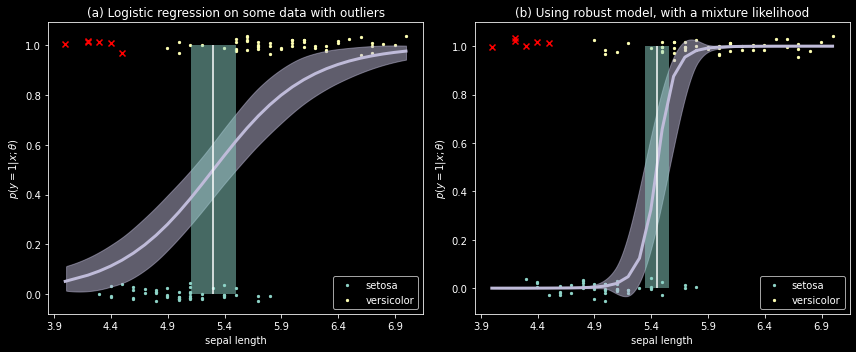

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

plot_training_data(X_total, y_total, n_inliers, n_outliers, ax1)
make_plot(trace_total, X_total, ax1)
ax1.set_title("(a) Logistic regression on some data with outliers")

plot_training_data(X_total, y_total, n_inliers, n_outliers, ax2)
make_plot(trace_robust, X_total, ax2)
ax2.set_title("(b) Using robust model, with a mixture likelihood")

fig.tight_layout()